In [1]:
from typing import Tuple
from matplotlib import pyplot as plt
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn
import numpy.typing as npt
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from IPython import display
from tqdm import tqdm

from datasets.cars import load_dataset
from datasets.cars_torch_dataset import Cars
from torch_ada_smooth import AdaSmooth
from torch_modules.inception_v3 import InceptionV3

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lr = 1e-3
batch_size = 128
epochs = 50
log_every = 10

In [3]:
dataset = Cars()

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 800, 800], generator=torch.Generator().manual_seed(21))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
data_loaders = (train_data_loader, test_data_loader)

In [ ]:
def train(data_loaders: Tuple[DataLoader, DataLoader], optimizer_type: str = "ada_smooth", epochs: int = 1,
          lr: float = 1e-2, log_every: int = 50, device: str = "cuda"):
    train_data_loader, test_data_loader = data_loaders

    model = InceptionV3(num_classes=196)
    model = model.to(device)
    model.train()

    if optimizer_type == "ada_smooth":
        optimizer = AdaSmooth(model.parameters(), learning_rate=lr, epsilon=1e-6, slow_decay=0.99, fast_decay=0.5)
    elif optimizer_type == "adam":
        optimizer = Adam(model.parameters(), lr=lr)
    else:
        print(f"Unsupported optimizer type: {optimizer_type}")
        return

    criterion = nn.CrossEntropyLoss()

    loss_history = []
    accuracy = []
    precision_micro = []
    recall_micro = []
    f1_micro = []

    step = 0
    for epoch in range(1, epochs + 1):
        for images, labels in tqdm(train_data_loader, total=len(train_data_loader)):
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.long().to(device)

            predictions, _ = model(images)

            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())

            step += 1

            if step % log_every == 0:
                model.eval()
                predictions, gt = [], []
                for images, labels in test_data_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    pred, _ = model(images)
                    predictions.append(pred.argmax(axis=1).cpu().detach())
                    gt.append(labels.cpu().detach())

                predictions = torch.cat(predictions).numpy()
                gt = torch.cat(gt).numpy()

                accuracy.append(accuracy_score(gt, predictions))
                precision_micro.append(precision_score(gt, predictions, average="micro"))
                recall_micro.append(recall_score(gt, predictions, average="micro"))
                f1_micro.append(f1_score(gt, predictions, average="micro"))
                model.train()
        
            display.clear_output(wait=True)

            f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
            f.set_figwidth(15)
            f.set_figheight(10)
            
            ax1.set_title("training loss")
            ax2.set_title("accuracy")
            ax3.set_title("precision micro")
            ax4.set_title("recall micro")
            ax5.set_title("f1 micro")

            ax1.plot(loss_history)
            ax2.plot(accuracy)
            ax3.plot(precision_micro)
            ax4.plot(recall_micro)
            ax5.plot(f1_micro)

            plt.show()
            print(f"Current loss: {loss_history[-1]}")
            if len(accuracy) > 0:
                print(f"Current accuracy: {accuracy[-1]}")
                print(f"Current precision: {precision_micro[-1]}")
                print(f"Current recall: {recall_micro[-1]}")
                print(f"Current f1: {f1_micro[-1]}")
    return loss_history, accuracy, precision_micro, recall_micro, f1_micro

In [ ]:
adam_lh, adam_a, adam_p, adam_r, adam_f1 = train(data_loaders, "adam", epochs = epochs, lr = lr, log_every = log_every)

In [ ]:
as_lh, as_a, as_p, as_r, as_f1 = train(data_loaders, "ada_smooth", epochs = epochs, lr = lr, log_every = log_every)

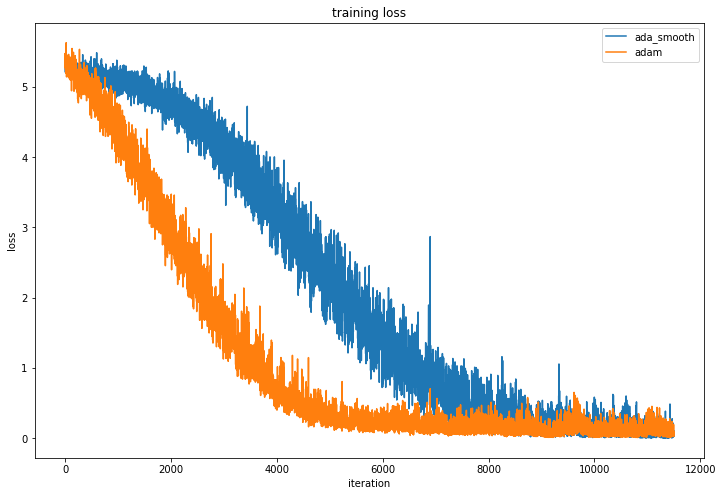

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(as_lh, label='ada_smooth')
plt.plot(adam_lh, label='adam')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("training loss")
plt.legend();

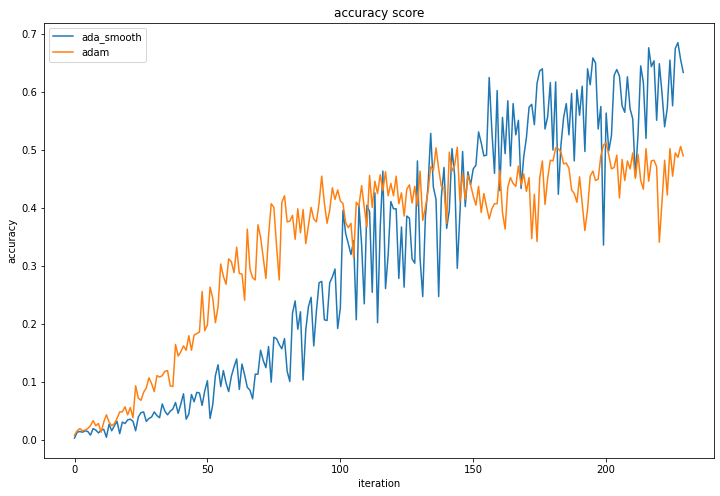

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(as_a, label='ada_smooth')
plt.plot(adam_a, label='adam')
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("accuracy score")
plt.legend();